# Making Predictions - House Price Model
In this exercise, we'll work with the housing price data from the previous checkpoint. 

## Load the dataset from Thinkful's database

In [9]:
#Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [13]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

# use the credentials to start a connection
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# Use the connection to extract SQL data
house_price = pd.read_sql_query('SELECT * FROM houseprices', con=engine)

#Close the connection after query is complete
engine.dispose()

## Clean and transform the data

In [14]:
#Drop features
drop_list = list((house_price.isnull().sum()/house_price.isnull().count()).sort_values(ascending=False).head(19).index)
drop_list.append('id')

house_price = house_price.drop(drop_list, axis=1)

#List of features that are string categoricals
str_cat_cols = list(house_price.describe(include=['O']).columns)

#Uniques within each variable
uniques = pd.DataFrame()
uni_col = []
num_uni = []
avgdiff_uni = []

for col in list(house_price.columns):
    uni_col.append(list(np.unique(house_price[col])))
    num_uni.append(len(np.unique(house_price[col])))
    try:
        avgdiff_uni.append(np.mean(np.diff(np.unique(house_price[col]))))
    except: 
        avgdiff_uni.append('N/A')
    
uniques['Category'] = list(house_price.columns)
uniques['Unique Values'] = uni_col
uniques['Num Uniques'] = num_uni
uniques['Avg Diff Among Uniques'] = avgdiff_uni


#List of features that are numerical categoricals
#If a numerical variable is categorical, its unique values will tend to be close to each other and there shouldn't
#be too many unique values 
num_cat_cols = []
for col in list(house_price.columns):
    if col not in str_cat_cols:   
        if ((list(uniques[uniques['Category']==col]['Avg Diff Among Uniques'])[0] < 2) or ((list(uniques[uniques['Category']==col]['Num Uniques'])[0] < 20) and (list(uniques[uniques['Category']==col]['Avg Diff Among Uniques'])[0] < 20))):
            num_cat_cols.append(col)
            
#List of features that are numerical continuous
cont_cols = []
for col in list(house_price.columns):
    if ((col not in str_cat_cols) and (col not in num_cat_cols)):
        cont_cols.append(col)
        
#Create new dataframe containing features of interest
#In previous modules, we determined that 'grlivarea', 'garagearea', 'totalbsmtsf', 'overallqual', and 'yearremodadd' were most effective
sale_df = house_price[['saleprice', 'grlivarea', 'garagearea', 'totalbsmtsf', 'overallqual', 'yearremodadd']]

sale_df.head(10)

,saleprice,grlivarea,garagearea,totalbsmtsf,overallqual,yearremodadd
0,208500,1710,548,856,7,2003
1,181500,1262,460,1262,6,1976
2,223500,1786,608,920,7,2002
3,140000,1717,642,756,7,1970
4,250000,2198,836,1145,8,2000
5,143000,1362,480,796,5,1995
6,307000,1694,636,1686,8,2005
7,200000,2090,484,1107,7,1973
8,129900,1774,468,952,7,1950
9,118000,1077,205,991,5,1950


## Split data into train and test sets

In [15]:
target_var = 'saleprice'
feature_set = list(sale_df.columns.drop(['saleprice']))

# X is the feature set 
X = sale_df[feature_set]
# Y is the target variable
Y = sale_df[target_var]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


## Build a linear regression model where the target variable is saleprice, only using our training set

In [16]:
# We add constant to the model as it's a best practice
# to do so ever ytime!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     743.0
Date:                Tue, 24 Sep 2019   Prob (F-statistic):               0.00
Time:                        09:04:50   Log-Likelihood:                -13988.
No. Observations:                1168   AIC:                         2.799e+04
Df Residuals:                    1162   BIC:                         2.802e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -8.456e+05   1.28e+05     -6.583   

Now it's time to make predictions using our trained model.

## Use test set to see how well the model does with making predictions.

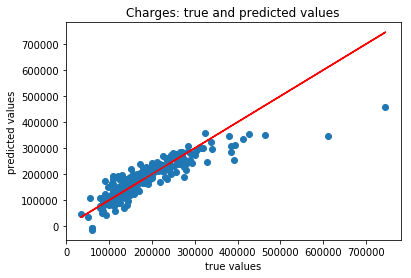

Mean absolute error of the prediction is: 25195.412028832838
Mean squared error of the prediction is: 1511930430.9587383
Root mean squared error of the prediction is: 38883.54961881359
Mean absolute percentage error of the prediction is: 15.35718234629606


In [17]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

The graph clearly shows that this model does a much better job at predicting lower target values (<350,000), and that when the target values get higher, the predicted values tend to skew lower. Overall, the model seems very good already, but it could always be a bit better.

## Can we improve this model?

In [18]:
#Let's add in the area interaction feature again and see what changes
sale_df['all_area'] = sale_df['grlivarea'] * sale_df['garagearea'] * sale_df['totalbsmtsf']

#Create training and testing sets
target_var = 'saleprice'
feature_set = list(sale_df.columns.drop(['saleprice']))

# X is the feature set 
X = sale_df[feature_set]
# Y is the target variable
Y = sale_df[target_var]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [19]:
# We add constant to the model as it's a best practice
# to do so ever ytime!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     697.7
Date:                Tue, 24 Sep 2019   Prob (F-statistic):               0.00
Time:                        09:07:22   Log-Likelihood:                -13934.
No. Observations:                1168   AIC:                         2.788e+04
Df Residuals:                    1161   BIC:                         2.792e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -8.343e+05   1.23e+05     -6.801   

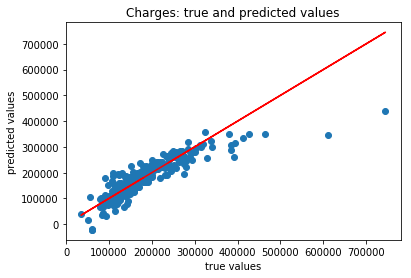

Mean absolute error of the prediction is: 26089.37730904534
Mean squared error of the prediction is: 1606825581.1342313
Root mean squared error of the prediction is: 40085.22896447308
Mean absolute percentage error of the prediction is: 16.164815561577196


In [20]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

This new model, with the area interaction feature included, has a higher R-squared value and lower AIC and BIC values, which would usually better fit, but we can see that all four calculated error terms are higher for the new model compared with the old model. Therefore, we can conclude that the area interaction feature introduces more error to our model and should be discarded in future iterations. 